# Data Dictionary

|Feature|Type|Description|
|---|---|---|
|Product_Code|*string*|The product name encoded|
|Warehouse|*string*|Warehouse ID|
|Product_Category|*string*|Product category of each product|
|Date|*string*|The date customer needs the product|
|Order_Demand|*string*|Order quantity|

In [255]:
# Import libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from numpy import array
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.metrics import RSquare
from tensorflow.keras.callbacks import EarlyStopping

In [256]:
# Read csv file and display shape.
df = pd.read_csv('../Data_Historical/df2.csv').iloc[:,1:]
df.shape

(924272, 5)

In [257]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0965,Whse_A,Category_006,2011-01-08,2
1,Product_1724,Whse_A,Category_003,2011-05-31,108
2,Product_1521,Whse_S,Category_019,2011-06-24,85000
3,Product_1521,Whse_S,Category_019,2011-06-24,7000
4,Product_1507,Whse_C,Category_019,2011-09-02,1250


In [258]:
# Set a seed.
tf.random.set_seed(12)

In [259]:
# Function to clean and resample order demand.
def get_product(data,product_code):
    df_init = data[data['Product_Code']==product_code]
    df_init['Date'] = pd.to_datetime(df_init['Date'])
    df_init = df_init.set_index('Date')
    df_out = pd.DataFrame(df_init['Order_Demand'].resample('W').sum())
    df_out.rename(columns={'Order_Demand':'demand'+'_'+product_code[-4:]}, inplace=True)
    return df_out
    

In [260]:
# split a univariate sequence
def split_sequence(sequence, n_steps):
 X, y = list(), list()
 
 for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
        break
    
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
 return array(X), array(y)

In [261]:
# Function to apply standard scaling to input.
def scale(X_train, X_test):
 # fit scaler
 scaler = StandardScaler()
 # Fit & transform train
 X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
 # Transform test
 X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
 return scaler, X_train, X_test

In [338]:
# Function to find the best epoch.
def find_best_epoch(history):
    model_history = pd.DataFrame(history).reset_index()
    model_history.rename(columns = {'index':'epoch'}, inplace=True)
    model_history['loss_diff'] = (model_history['loss'].map(lambda x: abs(x)) - model_history['val_loss'].map(lambda x: abs(x))).map(lambda x:abs(x))
    epoch = model_history[model_history['loss_diff']==model_history['loss_diff'].min()]
    epoch = int(epoch.iloc[0]['epoch'])
    return epoch

# Function to invert scale.
def invert_scale(scaler, X_train, X_test):
 new_row = [x for x in X]
 array = np.array(new_row)
 array = array.reshape(1, len(array))
 inverted = scaler.inverse_transform(array)
 return inverted[0, -1]

In [262]:
# Create dataframe of Product 1359.
prod_1359 = get_product(df, 'Product_1359')
prod_1359.head()

C:\Users\Zeonice\AppData\Local\Temp\ipykernel_14984\2577529180.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_init['Date'] = pd.to_datetime(df_init['Date'])


,demand_1359
Date,
2012-01-08,1226000
2012-01-15,1279000
2012-01-22,1401000
2012-01-29,1964000
2012-02-05,2591000


In [294]:
# define input sequence
raw_seq = prod_1359['demand_1359']

# choose a number of time steps
n_steps = 1

# split into samples
X, y = split_sequence(raw_seq, n_steps)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [295]:
X.shape

(261, 1, 1)

In [299]:
# Train test split.
X_train = X[0:-12]
X_test = X[-12:]
y_train = y[0:-12]
y_test = y[-12:]

# Standard scale input.
scaler, X_train_scaled, X_test_scaled = scale(X_train, X_test)

# LSTM

# define model
model = Sequential()
model.add(LSTM(9, activation='relu', return_sequences=True,  input_shape=(n_steps, n_features)))#, dropout=0.5, 
model.add(LSTM(4, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=.001), loss='mse')

# es = EarlyStopping(patience = 30)
# fit model
lstm = model.fit(X_train_scaled, y_train, epochs=500, verbose=0, validation_data=(X_test_scaled, y_test), batch_size=64) #, callbacks = [es]

# Find the best epoch.
lstm_history = pd.DataFrame(lstm.history).reset_index()
lstm_history.rename(columns = {'index':'epoch'}, inplace=True)
lstm_history['loss_diff'] = (lstm_history['loss'].map(lambda x: abs(x)) - lstm_history['val_loss'].map(lambda x: abs(x))).map(lambda x:abs(x))
best_epoch = lstm_history[lstm_history['loss_diff']==lstm_history['loss_diff'].min()]
best_epoch = int(best_epoch.iloc[0]['epoch'])

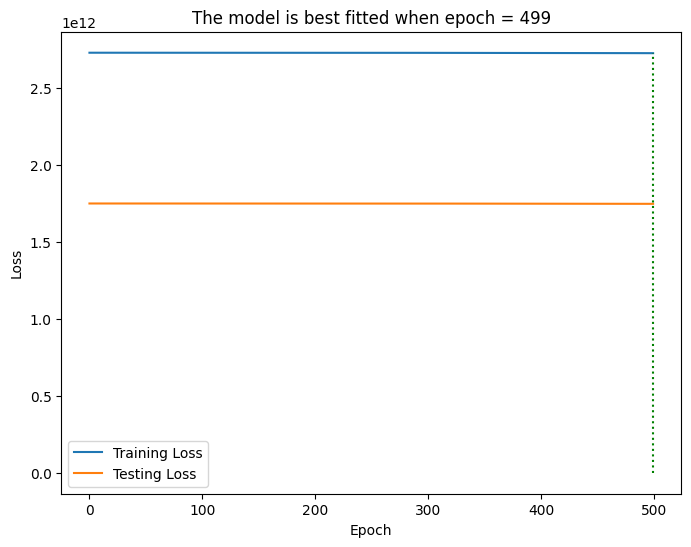

In [309]:
# Check out our train loss and test loss over epochs.
train_loss = lstm.history['loss']
test_loss = lstm.history['val_loss']

# Set figure size.
plt.figure(figsize=(8, 6))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.vlines(x=best_epoch, ymin=0,ymax=max(train_loss), colors='green', linestyles='dotted')

# Set title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'The model is best fitted when epoch = {best_epoch}')
plt.legend();

1/1 [==============================] - 0s 288ms/step


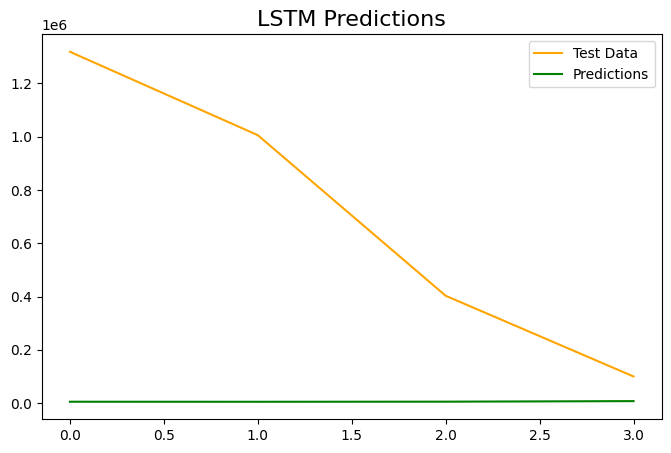

RMSE of LSTM model is: 850699.977357283


In [310]:
# Demonstrate predictions.
lstm = model.fit(X_train_scaled, y_train, epochs=best_epoch, verbose=0, validation_data=(X_test_scaled, y_test), batch_size=64)
preds = model.predict(X_test_scaled[-4:])

# Plot data.
plt.figure(figsize=(8,5))

# Plot testing data.
plt.plot(pd.DataFrame(y_test[-4:]).index, pd.DataFrame(y_test[-4:]), color = 'orange')

# Plot predicted test values.
plt.plot(pd.DataFrame(y_test[-4:]).index, preds, color = 'green')
plt.legend(['Test Data','Predictions'])
plt.title(label = 'LSTM Predictions', fontsize=16)
plt.show();

rmse_lstm = mean_squared_error(y_test[-4:], preds, squared=False)
print (f'RMSE of LSTM model is: {rmse_lstm}')

In [314]:
all_rmse_lstm =list()
for neuron in range (1,41):
    # define model
    model = Sequential()
    model.add(LSTM(neuron, activation='relu', return_sequences=False,  input_shape=(n_steps, n_features)))#, dropout=0.5, 
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=.001), loss='mse')

    es = EarlyStopping(patience = 30)
    # fit model
    lstm = model.fit(X_train_scaled, y_train, epochs=1000, verbose=0, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks = [es]) 
    
    # Find the best epoch.
    lstm_history = pd.DataFrame(lstm.history).reset_index()
    lstm_history.rename(columns = {'index':'epoch'}, inplace=True)
    lstm_history['loss_diff'] = (lstm_history['loss'].map(lambda x: abs(x)) - lstm_history['val_loss'].map(lambda x: abs(x))).map(lambda x:abs(x))
    best_epoch = lstm_history[lstm_history['loss_diff']==lstm_history['loss_diff'].min()]
    best_epoch = int(best_epoch.iloc[0]['epoch'])
    
    # Demonstrate predictions.
    lstm = model.fit(X_train_scaled, y_train, epochs=best_epoch, verbose=0, validation_data=(X_test_scaled, y_test), batch_size=32)
    preds = model.predict(X_test_scaled[-4:])
    
    rmse_lstm = mean_squared_error(y_test[-4:], preds, squared=False)
    all_rmse_lstm.append(rmse_lstm)

1/1 [==============================] - 0s 166ms/step


In [366]:
all_rmse_lstm =list()
neuron_1 = list()
neuron_2 = list()
for n1 in range (1,16):
    for n2 in range (1,11):
        # define model
        model = Sequential()
        model.add(LSTM(n1, activation='relu', return_sequences=True,  input_shape=(n_steps, n_features)))#, dropout=0.5, 
        model.add(LSTM(n2, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=.001), loss='mse')

        es = EarlyStopping(patience = 30)
        # fit model
        lstm = model.fit(X_train_scaled, y_train, epochs=1000, verbose=0, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks = [es]) 
    
        # Find the best epoch.
        best_epoch = find_best_epoch(lstm.history)
    
        # Demonstrate predictions.
        lstm = model.fit(X_train_scaled, y_train, epochs=best_epoch, verbose=0, validation_data=(X_test_scaled, y_test), batch_size=32)
        preds = model.predict(X_test_scaled[-4:])
    
        rmse_lstm = mean_squared_error(y_test[-4:], preds, squared=False)
        all_rmse_lstm.append(rmse_lstm)
        neuron_1.append(n1)
        neuron_2.append(n2)
        model.reset_states()
        print (f'n1: {n1}, n2: {n2}, rmse: {rmse_lstm}')
all_scores = pd.DataFrame({'neuron_1':neuron_1, 'neuron_2':neuron_2, 'rmse':all_rmse_lstm})

1/1 [==============================] - 0s 289ms/step
n1: 1, n2: 1, rmse: 855002.4371895024
1/1 [==============================] - 0s 290ms/step
n1: 1, n2: 2, rmse: 850276.3258921588
1/1 [==============================] - 0s 295ms/step
n1: 1, n2: 3, rmse: 855002.4371895024
1/1 [==============================] - 0s 282ms/step
n1: 1, n2: 4, rmse: 855002.4371895024
1/1 [==============================] - 0s 286ms/step
n1: 1, n2: 5, rmse: 843373.977070875
1/1 [==============================] - 0s 289ms/step
n1: 1, n2: 6, rmse: 843616.2651128316
1/1 [==============================] - 0s 280ms/step
n1: 1, n2: 7, rmse: 843661.9637123079
1/1 [==============================] - 0s 296ms/step
n1: 1, n2: 8, rmse: 843566.2538803812
1/1 [==============================] - 0s 284ms/step
n1: 1, n2: 9, rmse: 833852.3491150417
1/1 [==============================] - 0s 274ms/step
n1: 1, n2: 10, rmse: 832495.8978509662
1/1 [==============================] - 0s 277ms/step
n1: 2, n2: 1, rmse: 838308.960858037


In [368]:
all_scores.to_csv('../Data_Historical/all_score.csv')

In [369]:
all_rmse_lstm =list()
neuron_1 = list()
neuron_2 = list()
for n1 in range (16,31):
    for n2 in range (1,11):
        # define model
        model = Sequential()
        model.add(LSTM(n1, activation='relu', return_sequences=True,  input_shape=(n_steps, n_features)))#, dropout=0.5, 
        model.add(LSTM(n2, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=.001), loss='mse')

        es = EarlyStopping(patience = 30)
        # fit model
        lstm = model.fit(X_train_scaled, y_train, epochs=1000, verbose=0, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks = [es]) 
    
        # Find the best epoch.
        best_epoch = find_best_epoch(lstm.history)
    
        # Demonstrate predictions.
        lstm = model.fit(X_train_scaled, y_train, epochs=best_epoch, verbose=0, validation_data=(X_test_scaled, y_test), batch_size=32)
        preds = model.predict(X_test_scaled[-4:])
    
        rmse_lstm = mean_squared_error(y_test[-4:], preds, squared=False)
        all_rmse_lstm.append(rmse_lstm)
        neuron_1.append(n1)
        neuron_2.append(n2)
        model.reset_states()
        print (f'n1: {n1}, n2: {n2}, rmse: {rmse_lstm}')
all_scores_2 = pd.DataFrame({'neuron_1':neuron_1, 'neuron_2':neuron_2, 'rmse':all_rmse_lstm})

1/1 [==============================] - 1s 760ms/step
n1: 16, n2: 1, rmse: 855002.4371895024
1/1 [==============================] - 0s 391ms/step
n1: 16, n2: 2, rmse: 855002.4371895024
1/1 [==============================] - 0s 376ms/step
n1: 16, n2: 3, rmse: 696873.0464878902
1/1 [==============================] - 1s 510ms/step
n1: 16, n2: 4, rmse: 635048.2411339281
1/1 [==============================] - 0s 406ms/step
n1: 16, n2: 5, rmse: 666938.408494046
1/1 [==============================] - 0s 331ms/step
n1: 16, n2: 6, rmse: 577114.8401193792
1/1 [==============================] - 0s 330ms/step
n1: 16, n2: 7, rmse: 517105.75793599663
1/1 [==============================] - 1s 640ms/step
n1: 16, n2: 8, rmse: 582130.0080797774
1/1 [==============================] - 0s 270ms/step
n1: 16, n2: 9, rmse: 466444.8263736569
1/1 [==============================] - 0s 271ms/step
n1: 16, n2: 10, rmse: 669913.4918147206
1/1 [==============================] - 0s 255ms/step
n1: 17, n2: 1, rmse: 85500

In [370]:
all_scores_2.to_csv('../Data_Historical/all_score_2.csv')

In [331]:
# The model has lowest RMSE when n = 7.
pd.DataFrame(all_rmse_lstm)

,0
0,758649.279352
1,615027.411545
2,855002.437190
3,716493.189843
4,566342.043082
5,635596.499795
6,480892.322683
7,516259.846309
8,516489.051500
9,658765.815892


In [344]:
# define model
model.reset_states()
model = Sequential()
model.add(LSTM(20, activation='relu', return_sequences=True,  input_shape=(n_steps, n_features)))#, dropout=0.5, 
model.add(LSTM(7, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=.001), loss='mse')

es = EarlyStopping(patience = 30)
# fit model
lstm = model.fit(X_train_scaled, y_train, epochs=1000, verbose=0, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks = [es]) 
    
# Find the best epoch.
best_epoch = find_best_epoch(lstm.history)
print (best_epoch)
    
# Demonstrate predictions.
lstm = model.fit(X_train_scaled, y_train, epochs=best_epoch, verbose=0, validation_data=(X_test_scaled, y_test), batch_size=32)
preds = model.predict(X_test_scaled[-4:])
    
rmse_lstm = mean_squared_error(y_test[-4:], preds, squared=False)
rmse_lstm

999
1/1 [==============================] - 0s 306ms/step


486060.47917456046